In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')
from CMRx4DFlowMaskGeneration import *
from Utils import *
from einops import rearrange
import matplotlib.pyplot as plt


In [3]:
# Read one subject/case from a directory containing the corresponding .mat files
data_dir = '/mnt/nas/nas3/openData/rawdata/4dFlow/ChallengeData/Demo/TaskR1R2/TrainSet/Aorta/Center012/Philips_30T_Ingenia/P005/'

# `load_mat` takes the .mat file path and variable name (`key`) as input.
# It returns a lazy HDF5-like handle (h5py-style): data is not loaded into memory
# until you index it.
kdata_full = load_mat(data_dir + '/kdata_full.mat', key='kdata_full')
coilmap    = load_mat(data_dir + '/coilmap.mat',    key='coilmap')
segmask    = load_mat(data_dir + '/segmask.mat',    key='segmask')

# Use [()] to materialize the entire dataset into RAM as a NumPy array.
kdata_full = kdata_full[()]
coilmap = coilmap[()]

# kdata_full dimensions: (Nv, Nt, Nc, SPE, PE, FE)
Nv, Nt, Nc, SPE, PE, FE = kdata_full.shape

Mask shape: (1, 25, 1, 20, 96, 1), Actual undersampling rate: 10.00x


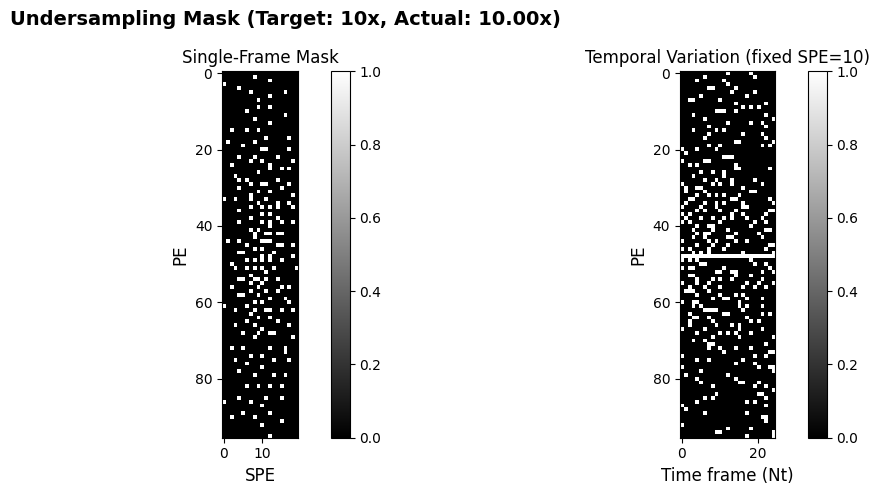

In [4]:
usrate = 10  # Desired undersampling factor (e.g., 10x)

# Target number of sampled k-space locations per 2D (PE, SPE) frame
total_points = PE * SPE // usrate

# fun_mask_gen_2d expects mask_size = (width, height) = (PE, SPE)
mask_size = (PE, SPE)

# Gaussian sampling density parameters:
sigma_x = PE / 5
sigma_y = SPE / 5

# Generate one undersampling mask per time frame.
# Output shape: (SPE, PE, Nt)
masks_spe_pe_t = fun_mask_gen_2d(
    mask_size=mask_size,
    total_points=total_points,
    pattern_num=Nt,
    sigma_x=sigma_x,
    sigma_y=sigma_y,
)

# Reshape to the expected tensor layout:
# (SPE, PE, Nt) -> (1, Nt, 1, SPE, PE, 1)
usmask = rearrange(masks_spe_pe_t, "spe pe t -> 1 t 1 spe pe 1")

# Empirical undersampling factor from the sampling density:
# mean(usmask) is the fraction of sampled points, so 1/mean is the effective acceleration.
actual_usrate = 1.0 / np.mean(usmask)
print(f"Mask shape: {usmask.shape}, Actual undersampling rate: {actual_usrate:.2f}x")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(
    f"Undersampling Mask (Target: {usrate}x, Actual: {actual_usrate:.2f}x)",
    fontsize=14,
    fontweight="bold",
)

# Panel 1: a single time-frame mask, displayed as (PE, SPE) for readability
im0 = axes[0].imshow(usmask[0, 0, 0, :, :, 0].T, cmap="gray")
axes[0].set_ylabel("PE", fontsize=12)
axes[0].set_xlabel("SPE", fontsize=12)
axes[0].set_title("Single-Frame Mask", fontsize=12)
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Panel 2: temporal evolution for a fixed SPE line (middle SPE index).
# Shows (PE vs time) sampling pattern at that SPE location.
im1 = axes[1].imshow(usmask[0, :, 0, SPE // 2, :, 0].T, cmap="gray")
axes[1].set_ylabel("PE", fontsize=12)
axes[1].set_xlabel("Time frame (Nt)", fontsize=12)
axes[1].set_title(f"Temporal Variation (fixed SPE={SPE // 2})", fontsize=12)
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

Coil combination after inverse FFT (fully sampled):

$$
\mathrm{img} = \mathbf{C}^{H}\mathbf{F}^{H}\mathbf{k}
$$

where $\mathbf{F}^{H}$ is the inverse Fourier transform along the spatial k-space axes, and $\mathbf{C}^{H}$ applies conjugate coil sensitivities and sums over coils.

Undersampled reconstruction applies the sampling operator $\mathbf{U}$ in k-space before the inverse FFT and coil combination:

$$
\mathrm{img}_{\mathrm{us}} = \mathbf{C}^{H}\mathbf{F}^{H}\mathbf{U}\mathbf{k}
$$

where $\mathbf{U}$ is the undersampling mask (`usmask`).

In [5]:
img = np.sum(k2i_numpy(kdata_full, ax=[-1, -2, -3]) * np.conj(coilmap), axis=-4)

kdata_us = kdata_full * usmask
img_us = np.sum(k2i_numpy(kdata_us, ax=[-1, -2, -3]) * np.conj(coilmap), axis=-4)

In [6]:
# Save the results for use in the next demo.
save_mat(f"{data_dir}/kdata_ktGaussian{usrate}.mat", 'kdata_ktGaussian', kdata_us.astype(np.complex64))
save_mat(f"{data_dir}/usmask_ktGaussian{usrate}.mat", 'usmask_ktGaussian', usmask)

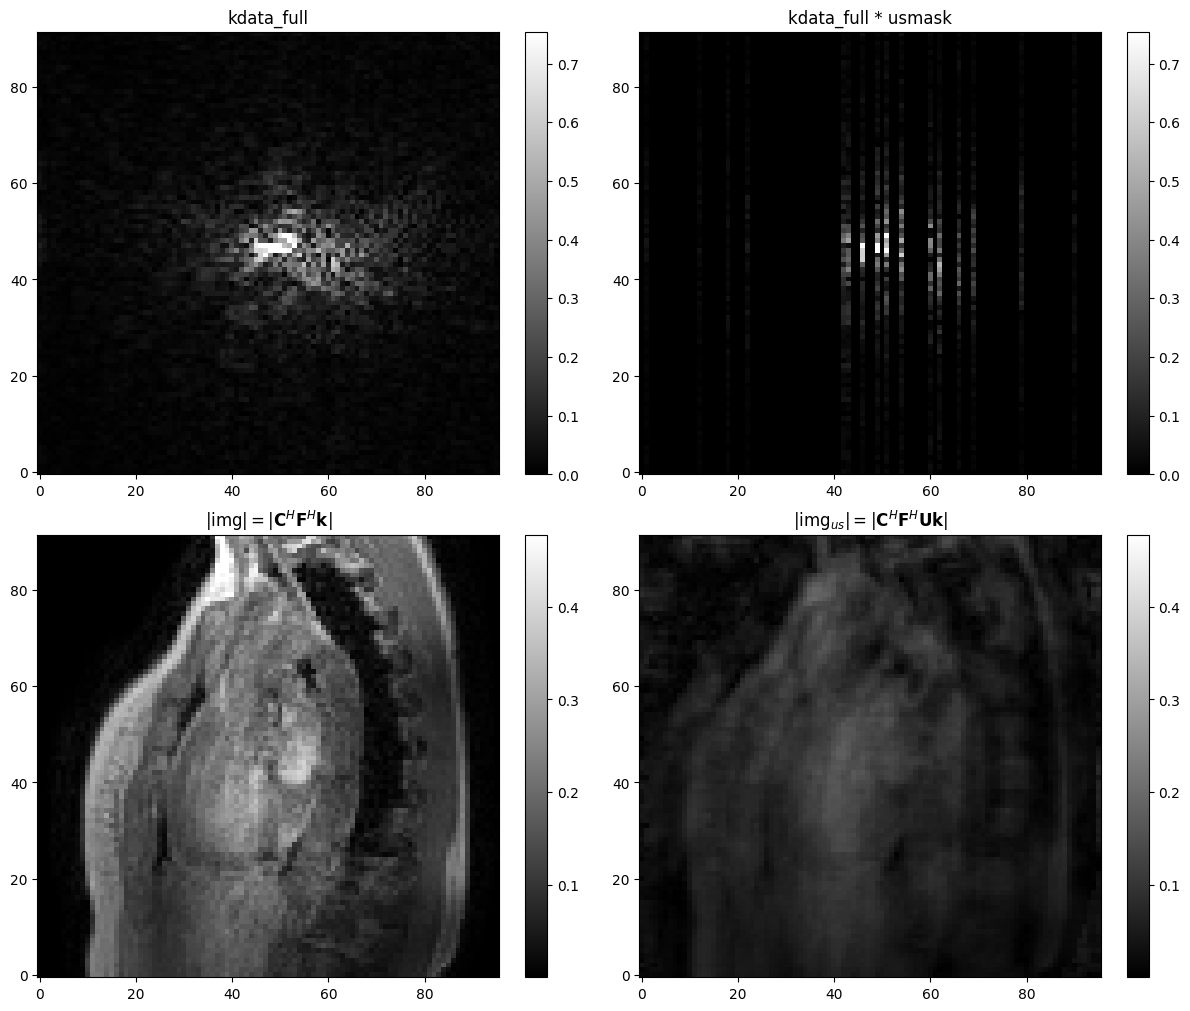

In [7]:
v_idx  = 0
t_idx  = 0
c_idx  = 0
spe_idx = 8  

# =========================
# Top row: k-space view (magnitude) at fixed SPE and FE
# =========================
full_mag = np.abs(kdata_full[v_idx, t_idx, c_idx, spe_idx, :, :])
us_mag   = np.abs(kdata_us  [v_idx, t_idx, c_idx, spe_idx, :, :])

pooled = np.concatenate([full_mag.ravel(), us_mag.ravel()])
vmin, vmax = np.percentile(pooled, [1, 99.9])

if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
    vmin = float(np.nanmin(pooled))
    vmax = float(np.nanmax(pooled))
    if vmin == vmax:
        vmin, vmax = vmin - 1.0, vmax + 1.0


# =========================
# Bottom row: image view (coil-combined) at fixed SPE and FE
# =========================
img_full_mag = np.abs(img[v_idx, t_idx, spe_idx, :, :])
img_us_mag   = np.abs(img_us[v_idx, t_idx, spe_idx, :, :])

pooled_img = np.concatenate([img_full_mag.ravel(), img_us_mag.ravel()])
vmin_i, vmax_i = np.percentile(pooled_img, [1, 99.9])

if (not np.isfinite(vmin_i)) or (not np.isfinite(vmax_i)) or (vmin_i == vmax_i):
    vmin_i = float(np.nanmin(pooled_img))
    vmax_i = float(np.nanmax(pooled_img))
    if vmin_i == vmax_i:
        vmin_i, vmax_i = vmin_i - 1.0, vmax_i + 1.0


# =========================
# Plot: 2x2 (top=k-space, bottom=image)
# =========================
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

im00 = axes[0, 0].imshow(full_mag.T, cmap="gray", vmin=vmin, vmax=vmax, origin="lower")
axes[0, 0].set_title("kdata_full", fontsize=12)
fig.colorbar(im00, ax=axes[0, 0], fraction=0.046)

im01 = axes[0, 1].imshow(us_mag.T, cmap="gray", vmin=vmin, vmax=vmax, origin="lower")
axes[0, 1].set_title("kdata_full * usmask", fontsize=12)
fig.colorbar(im01, ax=axes[0, 1], fraction=0.046)

im10 = axes[1, 0].imshow(img_full_mag.T, cmap="gray", vmin=vmin_i, vmax=vmax_i, origin="lower")
axes[1, 0].set_title(r"$|\mathrm{img}| = |\mathbf{C}^H\mathbf{F}^H\mathbf{k}|$", fontsize=12)
fig.colorbar(im10, ax=axes[1, 0], fraction=0.046)

im11 = axes[1, 1].imshow(img_us_mag.T, cmap="gray", vmin=vmin_i, vmax=vmax_i, origin="lower")
axes[1, 1].set_title(r"$|\mathrm{img}_{us}| = |\mathbf{C}^H\mathbf{F}^H\mathbf{U}\mathbf{k}|$", fontsize=12)
fig.colorbar(im11, ax=axes[1, 1], fraction=0.046)

plt.show()